[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

We'll log to a project, `langchain-academy`. 

## Messages as state

First, let's define some messages.

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [2]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model="granite3.3:8b", temperature=0)
llm.invoke(messages)

AIMessage(content="That's great! Whales are indeed fascinating. Besides whales, there are several other remarkable ocean mammals you might find interesting:\n\n1. **Dolphins**: Known for their intelligence and playful behavior, dolphins come in various species like the Bottlenose Dolphin and Orca (Killer Whale). They're part of the Delphinidae family, which also includes whales.\n\n2. **Manatees**: Also known as 'sea cows', these large aquatic mammals are herbivores that can be found in warm waters, particularly off the coasts of Florida, the Caribbean, and West Africa. There are three extant species: the Amazonian manatee, West Indian manatee, and West African manatee.\n\n3. **Seals**: These marine mammals belong to the family Phocidae and include species like the Common Seal and Harbor Seal. They are more streamlined for swimming compared to sea lions and have less visible external ears.\n\n4. **Sea Lions**: Unlike seals, sea lions are part of the Otariidae family and have external e

We can run our chat model in a simple graph with `MessagesState`.

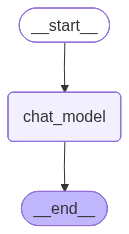

In [3]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are indeed fascinating. Besides whales, there are several other remarkable ocean mammals you might find interesting:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins come in various species like the Bottlenose Dolphin and Orca (Killer Whale). They're part of the Delphinidae family, which also includes whales.

2. **Manatees**: Also known as 'sea cows', these large aquatic mammals are herbivores that can be found in warm waters, particularly off the coasts of Florida, the Caribbean, and West Africa. There are three extant species: the Amazonian manatee, West Indian

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

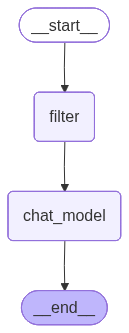

In [5]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are indeed fascinating. Besides whales, there are several other remarkable ocean mammals you might find interesting:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins come in various species like the Bottlenose Dolphin and Orca (Killer Whale). They're part of the Delphinidae family, which also includes whales.

2. **Manatees**: Also known as 'sea cows', these large aquatic mammals are herbivores that can be found in warm waters, particularly off the coasts of Florida, the Caribbean, and West Africa. There are three extant species: the Amazonian manatee, West Indian

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

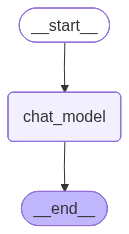

In [9]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [10]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [11]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are indeed fascinating. Besides whales, there are several other remarkable ocean mammals you might find interesting:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins come in various species like the Bottlenose Dolphin and Orca (Killer Whale). They're part of the Delphinidae family, which also includes whales.

2. **Manatees**: Also known as 'sea cows', these large aquatic m

In [12]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are indeed fascinating. Besides whales, there are several other remarkable ocean mammals you might find interesting:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins come in various species like the Bottlenose Dolphin and Orca (Killer Whale). They're part of the Delphinidae family, which also includes whales.

2. **Manatees**: Also known as 'sea cows', these large aquatic m

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://docs.langchain.com/oss/python/langgraph/add-memory#trim-messages), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

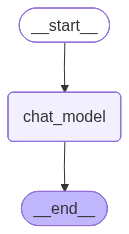

In [13]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOllama(model="granite3.3:8b"),
            allow_partial=True
        )

/home/abdul/langchain/3-langgraph_intro/.venv/lib/python3.12/site-packages/langchain_core/language_models/base.py:328: UserWarning: Using fallback GPT-2 tokenizer for token counting. Token counts may be inaccurate for non-GPT-2 models. For accurate counts, use a model-specific method if available.
  return len(self.get_token_ids(text))


ImportError: Could not import transformers python package. This is needed in order to calculate get_token_ids. Please install it with `pip install transformers`.

In [ ]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

In [ ]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r